In [877]:
import random
from operator import itemgetter
import numpy as np
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
import pandas as pd

In [402]:
class Location(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y

In [403]:
def compute_sub_distance(subroute: tuple) -> float:
    a, b = subroute
    avec = np.asarray([a.x, a.y]).reshape(-1, 2)
    bvec = np.asarray([b.x, b.y]).reshape(-1, 2)
    return cdist(avec, bvec, metric='euclidean')[0][0]

In [688]:
def compute_route_distance(route: list) -> float:
    route = list(zip(route, route[1::]))
    return sum([compute_sub_distance(sub) for sub in route])

In [453]:
def make_locations(num_locations: int) -> list:
    return [Location(random.uniform(0, 10), random.uniform(0, 10)) for i in range(0, num_locations)]

In [1019]:
def make_individual(locations: int) -> list:
    locs = locations.copy()
    start, end = locs[0:1].copy(), locs[0:1].copy()
    middle = locs[1:].copy()
    random.shuffle(middle)
    return start+middle+end

In [1020]:
def make_population(pop_size: int, num_locations: int) -> list:
    locations = make_locations(num_locations)
    population = list()
    for sample in range(0, pop_size):
        route = make_individual(locations)
        population.append(route)
    return population

In [1021]:
def rank_routes(population: list) -> list:
    all_distances = [compute_route_distance(individual) for individual in population]
    ranking = list(zip(*sorted(zip(all_distances, population), key=itemgetter(0))))
    format_ranking = list()
    for ix, distance in enumerate(ranking[0]):
        format_ranking.append((distance, ranking[1][ix]))
    return format_ranking

In [1022]:
def tourn_selection(ranked_pop: list, elite_size: int, tourn_stages: int = 1) -> list:
    selected = list()
    
    # ELITE
    elite, rest = ranked_pop[:elite_size], ranked_pop[elite_size:]
    selected.append(elite[0][1])
    
    # TOURNAMENT
    stage_participants = rest.copy()
    tourn_survivor = None
    for stage in range(0, tourn_stages):
        stage_survivor = list()
        perm = np.random.permutation(len(stage_participants))
        rand = np.asarray(stage_participants)[perm]
        if len(rand) % 2 > 0:
            rand = rand[:-1]
        matches = rand.reshape(int(len(rand)/2), 2, 2)
        
        for (a, b) in matches:
            if a[0] <= b[0]:
                winner = a
            else:
                winner = b
            stage_survivor.append(winner)
        stage_participants = stage_survivor
    tourn_survivor = stage_participants  
    
    survivors = [(fitness, loc) for fitness,loc in elite] + [(fitness, loc) for fitness,loc in np.asarray(tourn_survivor)]
            
    return survivors

In [1023]:
def prob_selection(ranked_pop: list, elite_size: int) -> list:
    selected = list()
    
    perf_fit = ranked_pop[0][0]
    
    # PROBABILITY OF SURVIVAL DIRECTLY DEPENDS ON DISTANCE
    survivors = list()
    for distance, route in ranked_pop:
        fitness = perf_fit/distance
        if np.random.binomial(1, fitness) == 1:
            survivors.append((distance, route))
            
    return survivors

In [1261]:
def breed(a: list, b: list) -> list:
    child = list()

    nums = np.random.randint(1, len(a)-1, 2)
    startGene, endGene = min(nums), max(nums)

    child = b.copy()
    child[startGene:endGene] = a[startGene:endGene]

    return child

In [1262]:
def breed_population(pool: list, elite_size: int, breed_to_size = None) -> list:
    children = []
    
    elite = [x[1] for x in sorted(pool, key=itemgetter(0))[:elite_size]]
    children += elite
    
    pool = random.sample(pool, len(pool))
    
    if breed_to_size:
        upsample = breed_to_size
        pool += random.sample(pool, upsample-len(pool))
    else:
        upsample = len(pool)-elite_size
    for i in range(0, upsample):
        child = breed(pool[i][1], pool[len(pool)-i-1][1])
        children.append(child)
        
    return children

In [1263]:
def swap_mutate(individual: list, chance: float) -> list: # chance of mutation for each gene
    for topos in range(1, len(individual)-1):
        if np.random.binomial(1, chance) == 0:
            continue
            
        frompos = int(random.random() * len(individual))
        if (frompos in [0, len(individual)-1]) or (frompos == topos):
            continue
        
        loca = individual[frompos]
        locb = individual[topos]
        individual[frompos] = locb
        individual[topos] = loca
        
    return individual

In [1264]:
def swap_mutate_population(population: list, chance: float) -> list:
    return [swap_mutate(ind, chance) for ind in population]

In [1265]:
def compute_metrics(ranked_pop: list):
    mean_dist = np.mean([x[0] for x in ranked_pop])
    min_dist = np.min([x[0] for x in ranked_pop])
    max_dist = np.max([x[0] for x in ranked_pop])
    pop_size = len(ranked_pop)
    return {
        "mean_dist": mean_dist,
        "min_dist": min_dist,
        "max_dist": max_dist,
        "pop_size": pop_size
    }

In [1266]:
def evolve(population: list, selection: str, elite_size: int, chance: float, breed_to_size: int,
           tournament_stages: int = 1) -> list:  
    ranked_pop = rank_routes(population)
    metrics = compute_metrics(ranked_pop)
    if selection == "prob":
        sel = prob_selection(ranked_pop, elite_size)
    elif selection == "tourn":
        sel = tourn_selection(ranked_pop, elite_size, tournament_stages)
    else:
        raise ValueError('unknown selection method')
    children = breed_population(sel, elite_size, breed_to_size)
    next_gen = swap_mutate_population(children, chance)
    return next_gen, metrics

In [1267]:
def plot_progress(metrics: list, exclude: list = ["pop_size"]) -> None:
    plt.figure(figsize=(12, 8))
    plt.title('Evolutionary Progress', size=20)
    plt.xlabel("Evolutionary Steps")
    plt.ylabel("Total Euclidean Distance Needed")
    keys = list(metrics[0].keys())
    print(pd.DataFrame.from_records(total_metrics))
    for key in keys:
        key_final = dict()
        key_values = list()
        for run in metrics:
            key_values.append(run[key])
            
        key_final[key] = key_values
        
        if key not in exclude:
            plt.plot(list(key_final.values())[0], label=key)
    plt.legend()
    plt.show()

In [1290]:
EVOLUTION_STEPS = 500
NUM_INDIVIDUALS = 1000
NUM_LOCATIONS = 50
ELITE_SIZE = 1
MUTATE_CHANCE = 0.01
OFFSET_EARLY_STOPPING = 20
SOFT_PATIENCE = 50
CONVERGENCE_CRITERIUM = 0.01
BREED_TO_SIZE = NUM_INDIVIDUALS
SELECTION = 'tourn'

total_metrics = list()

population = make_population(NUM_INDIVIDUALS, NUM_LOCATIONS)
min_dist = list()
for step in range(0, EVOLUTION_STEPS):
    population, metrics = evolve(population, SELECTION, ELITE_SIZE, MUTATE_CHANCE, BREED_TO_SIZE)
    total_metrics.append(metrics)
    min_dist.append(metrics["min_dist"])
    if (len(min_dist) >= OFFSET_EARLY_STOPPING):
        cum_diff = [abs(t - s) for s, t in zip(min_dist[-SOFT_PATIENCE:], min_dist[-SOFT_PATIENCE:][1:]) if (t - s) < 0]
        if np.mean(cum_diff) <= 0.5:
            break

       max_dist   mean_dist    min_dist  pop_size
0    292.600615  252.669883  205.839039      1000
1    301.382469  244.287343  200.868517      1001
2    285.088791  236.803056  180.774675      1001
3    274.091449  229.367214  179.114137      1001
4    270.374233  222.078122  157.839978      1001
5    262.306606  215.216251  157.839978      1001
6    253.371669  207.207397  151.909861      1001
7    259.260557  200.837126  150.710780      1001
8    244.598913  194.382217  146.226957      1001
9    241.943403  188.186525  128.778456      1001
10   233.690369  182.535432  120.619332      1001
11   221.459290  176.605482  115.530674      1001
12   223.585286  170.322746  112.664626      1001
13   207.348182  164.340030  112.664626      1001
14   210.107761  159.136644  101.619704      1001
15   203.926463  153.724512  101.619704      1001
16   194.727295  148.177694  101.619704      1001
17   182.745150  142.250572  101.298458      1001
18   188.697074  135.455793   91.633747      1001


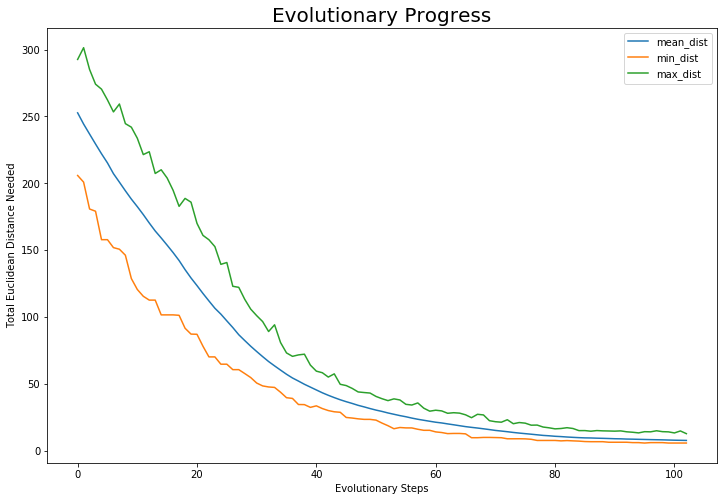

In [1291]:
plot_progress(total_metrics) # "tourn"